## Optimizing Training Pipeline in Pytorch

To improve training performance in any deep learning pipeline, pytorch suggests few extra additions of codes in exitin pipeline.
These additions are explained and mentioned well here in [Performance Tuning Guide](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) . In this notebook you will encounter few of such features with hands-on dedicated for GPU Computing.

In [28]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

### Set GPU Device if multiple

In [3]:
!nvidia-smi

Sun Jan 30 19:52:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 25%   60C    P2   134W / 250W |   3139MiB / 11178MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [4]:
##############################################################
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="2"
##############################################################

### Use device for `cuda` or `cpu` based on availability

In [5]:
####################################################################
#GPU using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
####################################################################

device(type='cuda')

In [6]:
config = dict(
    IMAGE_PATH= "nih-dataset/nih-15-class",
    saved_path="saved/resnet18.pt",
    lr=0.001, 
    EPOCHS = 5,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=8,
    USE_AMP = True,
    channels_last=False)
####################################################################

In [7]:
# For custom operators, you might need to set python seed
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])

### Create tensors directly on the target device

Instead of calling `torch.rand(size).cuda()` to generate a random tensor, produce the output directly on the target device: `torch.rand(size, device=torch.device('cuda'))`.

This is applicable to all functions which create new tensors and accept device argument: `torch.rand(), torch.zeros(), torch.full()` and similar.

CUDA Convolution Benchmarking: Best Convolution Algo but may loose reproducibility if True

In [8]:
# If researcher and wants to reproducuce: False
# If developer wants performance: True
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

Apply Data Transforms (Aumentations + Processing)

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
my_path = '../../../dataset/NIH_WHOLE_DATASET/nih-15-class'
os.listdir(my_path)

['Hernia',
 'Nodule',
 'Fibrosis',
 'Consolidation',
 'Cardiomegaly',
 'No Finding',
 'Emphysema',
 'Effusion',
 'Pneumothorax',
 'Pneumonia',
 'Atelectasis',
 'Infiltration',
 'Pleural_Thickening',
 'Edema',
 'Mass']

In [11]:
import torchvision
images = torchvision.datasets.ImageFolder(root=my_path,transform=data_transforms['test'])
print(len(images))
other, train_data,valid_data,test_data = torch.utils.data.dataset.random_split(images,[125000,10000,3000,3537])

141537


In [12]:
train_dl = torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = torch.utils.data.DataLoader(dataset = valid_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
test_dl = torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

Optimizers:
Gradient Descent:-
    a. Stoicastic Gradient Descent bs = 1; 'n' number of examples. 'n / 1' number of data loader/steps for 1 Epoch
    b. Mini-Batch Gradient Descent bs = 32; 'n' number of examples. 'n / 32' number of dataloaders/step for 1 Epoch 
    c. Full Batch Gradient Descent bs = total_number_of_samples number of dataloader/steps = 1 for 1 Epoch

In [13]:
len(train_dl)

313

tensor([10,  8, 12, 11, 10, 10, 10,  4, 10, 10, 10, 10,  8,  5, 10,  9,  8,  4,
        10,  8,  2, 13, 10,  4, 10,  8, 10, 10,  8,  2,  2, 11])


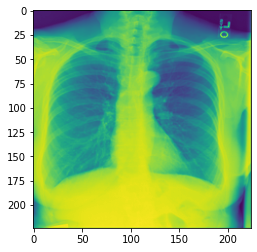

In [14]:
import matplotlib.pyplot as plt
a = iter(valid_dl)
b = next(a)
print(b[1])
plt.imshow(b[0][0][0])

Load Model : Pretrained from torchvision model zoo or Saved model

In [15]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True) # data again divided by 255

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier = nn.Sequential(
                                        nn.Dropout(0.5),
                                        nn.Conv2d(512, 15, kernel_size=(1, 1), stride=(1, 1)),
                                        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

model = squeezenet

In [16]:
model.load_state_dict(torch.load('saved15/exlnet1.pt'))

<All keys matched successfully>

In [17]:
#Channel Last Optimization in Model

model = model.to(config['device'])

In [18]:
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
# Loss Function
criterion = nn.CrossEntropyLoss()

### Training Pipeline Starts

In [19]:
def train_model(model,criterion,optimizer,num_epochs=10):

    since = time.time()                                            
    batch_ct = 0
    example_ct = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        #Training
        model.train()
        run_corrects = 0
        for x,y in train_dl:
            x = x.to(config['device'])
            y = y.to(config['device'])
            
            optimizer.zero_grad()
            #optimizer.zero_grad(set_to_none=True)
            ######################################################################
            
            train_logits = model(x) #Input = [BS,3,224,224] (Image) -- Model --> [BS,4] (Output Scores)
            _, train_preds = torch.max(train_logits, 1)
            train_loss = criterion(train_logits,y)
            run_corrects += torch.sum(train_preds == y.data)
            
            train_loss.backward() # Backpropagation this is where your W_gradient
            loss=train_loss

            optimizer.step() # W_new = W_old - LR * W_gradient 
            example_ct += len(x) 
            batch_ct += 1
            
            ########################################################################
            # Stores Wandb Logs here
            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
            ########################################################################
        
        #validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        # Disable gradient calculation for validation or inference using torch.no_rad()
        with torch.no_grad():
            for x,y in valid_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
            
        epoch_loss = running_loss / len(valid_data)
        epoch_acc = running_corrects.double() / len(valid_data)
        train_acc = run_corrects.double() / len(train_data)
        print("Train Accuracy",train_acc.cpu())
        print("Validation Loss is {}".format(epoch_loss))
        print("Validation Accuracy is {}".format(epoch_acc.cpu()))

            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), config['saved_path'])

In [20]:
def train_log(loss, example_ct, epoch):
    loss = float(loss)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [24]:
train_model(model, criterion, optimizer, num_epochs=2)

Epoch 0/1
----------
Loss after 00768 examples: 1.825
Loss after 01568 examples: 1.938
Loss after 02368 examples: 1.950
Loss after 03168 examples: 1.910
Loss after 03968 examples: 1.910
Loss after 04768 examples: 2.207
Loss after 05568 examples: 1.904
Loss after 06368 examples: 2.039
Loss after 07168 examples: 1.954
Loss after 07968 examples: 2.230
Loss after 08768 examples: 2.452
Loss after 09568 examples: 1.961
Train Accuracy tensor(0.4279, dtype=torch.float64)
Validation Loss is 2.030156386057536
Validation Accuracy is 0.416
Epoch 1/1
----------
Loss after 10352 examples: 1.966
Loss after 11152 examples: 1.894
Loss after 11952 examples: 1.971
Loss after 12752 examples: 2.259
Loss after 13552 examples: 1.908
Loss after 14352 examples: 2.323
Loss after 15152 examples: 1.736
Loss after 15952 examples: 1.843
Loss after 16752 examples: 2.105
Loss after 17552 examples: 1.829
Loss after 18352 examples: 2.219
Loss after 19152 examples: 1.931
Loss after 19952 examples: 1.533
Train Accuracy t

In [29]:
import torch.nn.functional as F
model.eval()
running_loss = 0.0
running_corrects = 0
total = 0
preds = []
pred_labels = []
labels = []

        # Disable gradient calculation for validation or inference using torch.no_rad()
with torch.no_grad():
            for x,y in test_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                predict_prob = F.softmax(valid_logits)
                _,predictions = predict_prob.max(1)
                predictions = predictions.to('cpu')
                
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
                predict_prob = predict_prob.to('cpu')
                
                pred_labels.extend(list(predictions.numpy()))
                preds.extend(list(predict_prob.numpy()))
                y = y.to('cpu')
                labels.extend(list(y.numpy()))
            
epoch_loss = running_loss / len(test_data)
epoch_acc = running_corrects.double() / len(test_data)
print("Test Loss is {}".format(epoch_loss))
print("Test Accuracy is {}".format(epoch_acc.cpu()))

Test Loss is 1.724824034193663
Test Accuracy is 0.45858071812270285


In [32]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
precision_recall_fscore_support(np.array(labels), np.array(pred_labels))

(array([0.28125   , 0.40909091, 0.        , 0.33333333, 0.30478589,
        0.25      , 0.        , 0.        , 0.2295082 , 0.21428571,
        0.52712582, 0.28      , 0.        , 0.        , 0.16666667]),
 array([0.09608541, 0.11688312, 0.        , 0.01449275, 0.33611111,
        0.03508772, 0.        , 0.        , 0.13972056, 0.046875  ,
        0.91090426, 0.04666667, 0.        , 0.        , 0.06666667]),
 array([0.14323607, 0.18181818, 0.        , 0.02777778, 0.31968296,
        0.06153846, 0.        , 0.        , 0.17369727, 0.07692308,
        0.66780405, 0.08      , 0.        , 0.        , 0.0952381 ]),
 array([ 281,   77,  103,   69,  360,   57,   44,    7,  501,  128, 1504,
         150,   80,   41,  135]))

In [42]:
#y_pred = np.transpose([pred[:, 1] for pred in preds])
roc_auc_score(np.array(labels), np.array(preds), multi_class='ovr')

0.7604447051760369